## Creating Lo-Fi data for steady shear rheometry
In this notebook, the synthetic generation of Lo-Fi data is introduced based on the given Hi-Fi data. For this case, shear rate (`SR`) and temperature (`T`) are the independent variables, while the steady viscosity (`eta`) is the dependent variable for which we wish to generate Lo-Fi data. The output of this notebook is `Data_LF_FS.xlsx`, which is the Lo-Fi flow sweep data.

### Importing dependencies
Note that the below classses from `sklearn` are called as kernels to generate Lo-Fi data. In reality, only the linear regression (`LR`) kernel is used.

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

### Loading Hi-Fi data to generate Lo-Fi data based on it.
In the below cell, it is initially assumed that all Hi-Fi flow sweeps, i.e., `eta` vs. `SR` curves at different temperatures, are supplied to generate Lo-Fi data. In the manuscript, however, these curves are systematically masked during the Lo-Fi data generation (here) and also the NN training (will be shown). For instance, by masking the `Temperature = 30` flow curve below (and while training the NN), the interpolation of MFNN @ $30^\circ\text{C}$ is tested and so on. Also note that the shear rate and viscosity are log-scaled. For this case, the $30^\circ\text{C}$ flow curve is masked.

In [2]:
np.set_printoptions(suppress=True)
path = os.getcwd()
files = os.listdir(path)
df = {}
#Reading the Hi-Fi data
url = 'https://github.com/procf/RhINNs/raw/main/MFNN/SteadyState/Data_HF_FS.xlsx'
#Uncomment the below line if running locally
#url = pd.ExcelFile('Data_HF_FS.xlsx')

df = pd.read_excel(url, sheet_name=None)
data = [[k,v] for k,v in df.items()] #k is the sheet name, v is the pandas df
i = 0

#Exclude flow sweeps as needed
# data[i][1] = data[i][1][data[i][1].Temperature != 10]
# data[i][1] = data[i][1][data[i][1].Temperature != 20]
# data[i][1] = data[i][1][data[i][1].Temperature != 25]
data[i][1] = data[i][1][data[i][1].Temperature != 30]
# data[i][1] = data[i][1][data[i][1].Temperature != 40]
# data[i][1] = data[i][1][data[i][1].Temperature != 50]

#Sample uniformly as needed
# data[i][1] = data[i][1].iloc[::8]

SR, T, eta = data[i][1]['ShearRate'], data[i][1]['Temperature'], data[i][1]['Viscosity']

#Log-scaling shear rate and viscosity
SR = np.log10(SR)
eta = np.log10(eta)

df = np.stack((SR, T, eta), axis=1)

### Performing regression on Hi-Fi data by calling `fitter` with a desired kernel, e.g., `LR`
Here, `N_T` viscosity vs. shear rate curves between 10 and $50^\circ\text{C}$ are generated. Other kernels may be used to evaluate the MFNN sensitivity to the quality of Lo-Fi data.

In [5]:
X = np.stack((SR, T), axis=1)
y = eta
lb = [min(X[:,0]), min(X[:,1])]
ub = [max(X[:,0]), max(X[:,1])]
N_T = 9
N_SR = 10*int(len(X)/N_T)

SR_f=np.linspace(lb[0], ub[0], N_SR)
T_f=np.linspace(10., 50., N_T)
X_f=np.array(list(itertools.product(SR_f, T_f)))

def fitter(mode, X, X_pred):
    if mode == 'LR':
        poly = PolynomialFeatures(degree=1)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        X_pred = poly.fit_transform(X_pred)
        return model.predict(X_pred)
    elif mode == 'EN':
        model = ElasticNet(alpha=0.1, l1_ratio=0.5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'RF':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'SVR':
        model = SVR(kernel='rbf', C=2, gamma=5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'GB':
        model = GradientBoostingRegressor(n_estimators=100,
                                          learning_rate=0.1, max_depth=2, random_state=0)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'kNN':
        model = model = KNeighborsRegressor(n_neighbors=2)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'BR':
        model = BayesianRidge()
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'MLP':
        model = MLPRegressor(hidden_layer_sizes=(20, 20, 20),
                             activation='tanh', max_iter=50000,
                            random_state=2, solver='lbfgs')
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'Ridge':
        model = Ridge(alpha=1.0)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'Lasso':
        model = Lasso(alpha=0.1)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'DT':
        model = DecisionTreeRegressor(max_depth=5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'AB':
        base_model = DecisionTreeRegressor(max_depth=3)
        model = AdaBoostRegressor(base_model, n_estimators=50, learning_rate=0.1)
        model.fit(X, y)
        return model.predict(X_pred)
y_f = fitter('LR', X, X_f) #LR, EN, RF, SVR, GB, kNN, BR

### Visualizing the generated Lo-Fi data against the Hi-Fi data

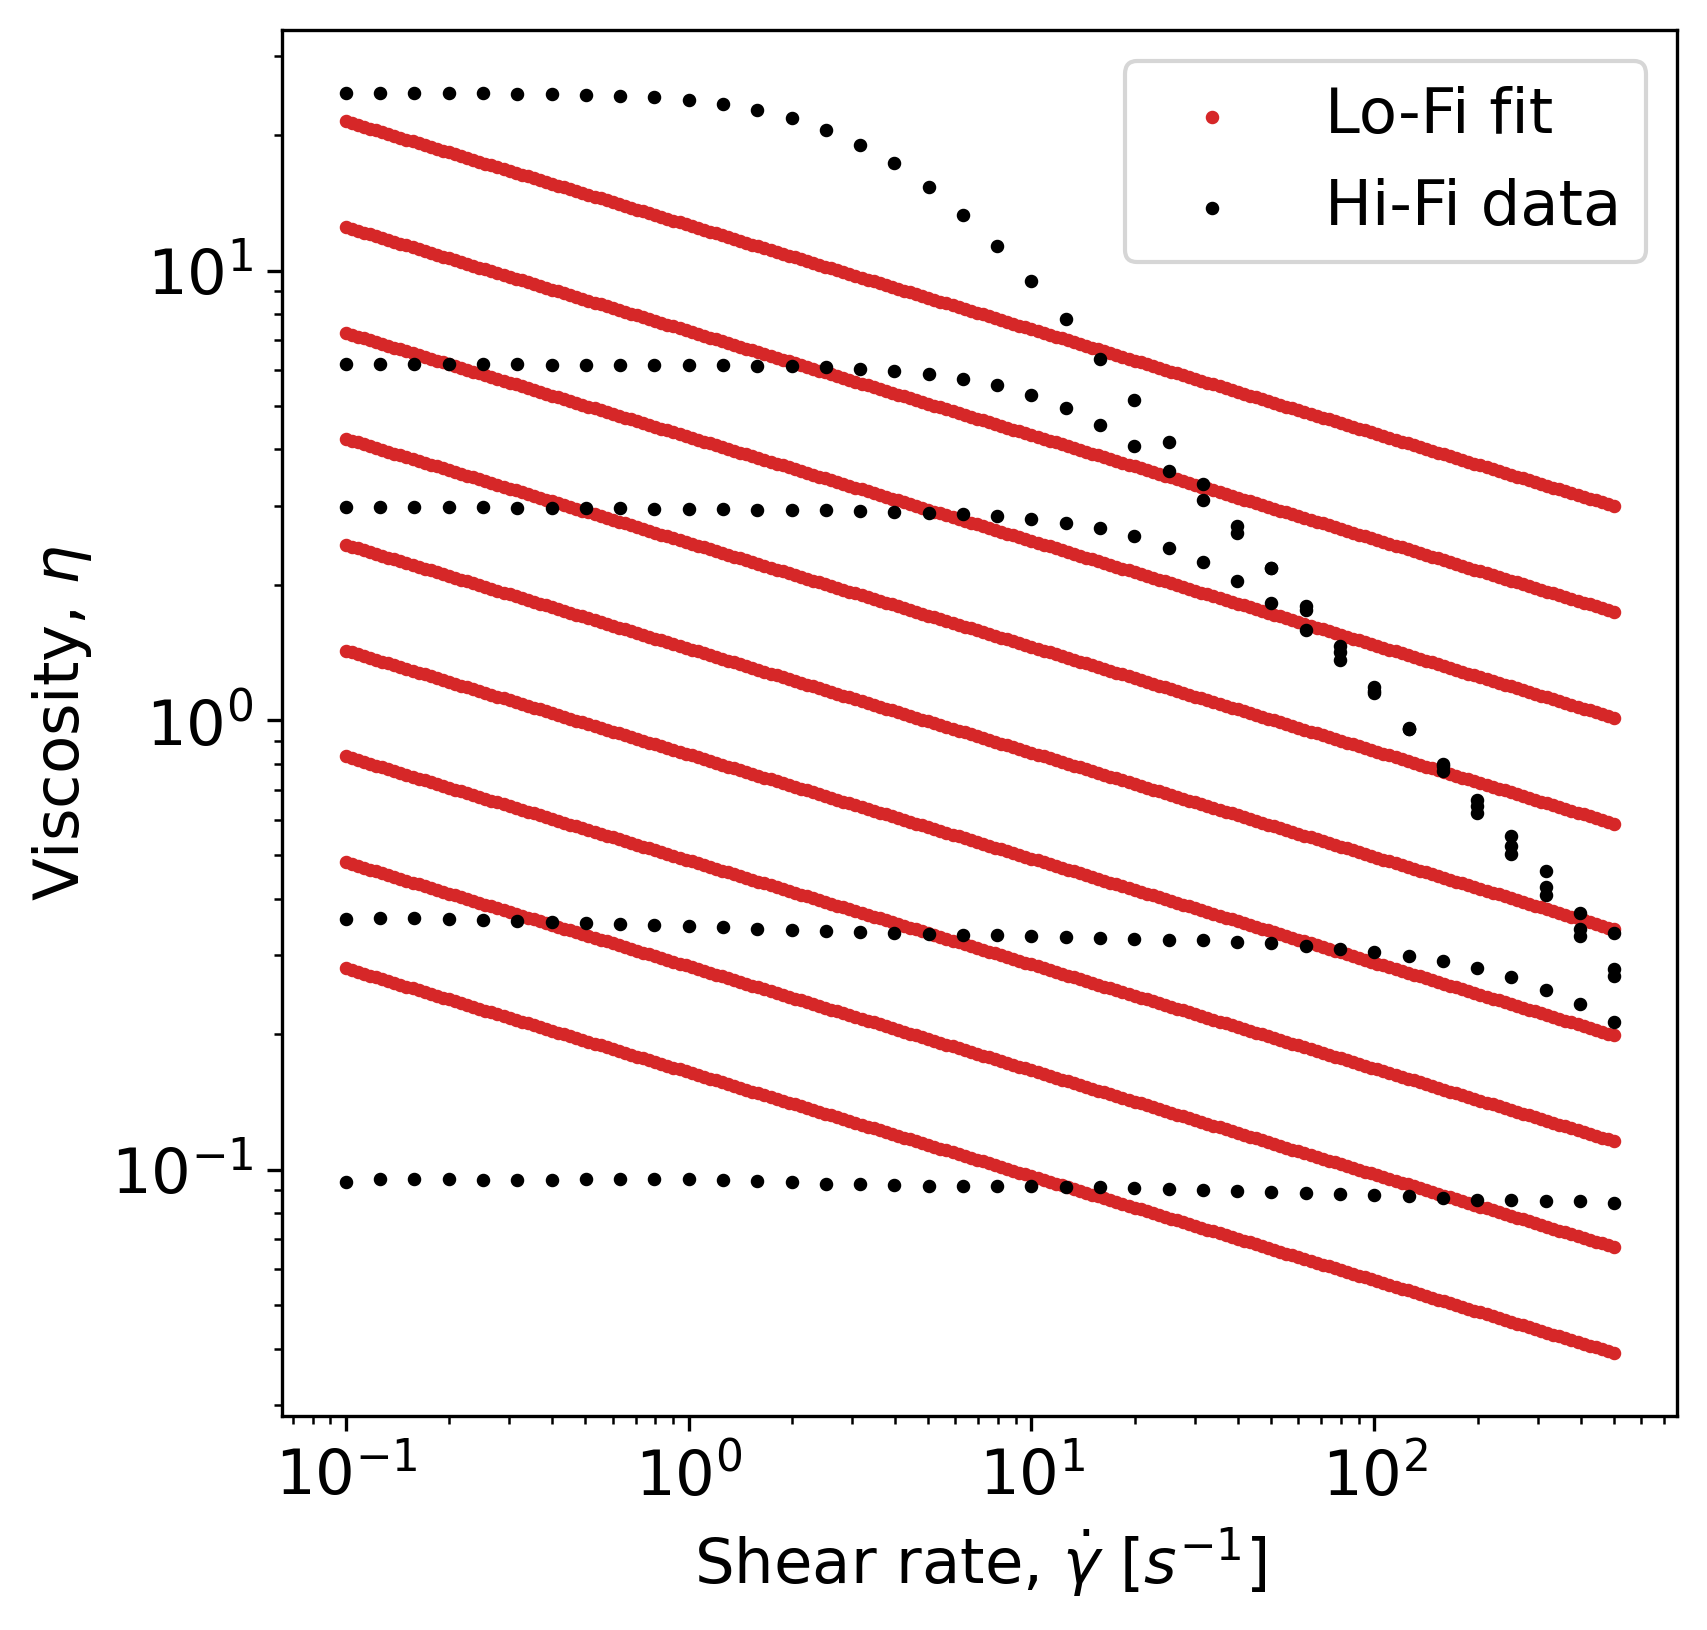

In [6]:
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title
plt.scatter(10**X_f[:,0], 10**y_f, label='Lo-Fi fit', color='tab:red', s=5)
plt.scatter(10**X[:,0], 10**y, label='Hi-Fi data', color='k', s=5)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Viscosity, $\eta$')
plt.xlabel('Shear rate, $\dot{\gamma}$ [$s^{-1}$]')
plt.show()

### Exporting the Lo-Fi data to `Data_LF_FS.xlsx` (optional)
You may store this excel file locally, or use Google Colab, which has access to `Data_LF_FS.xlsx` on GitHub.

In [17]:
SR_LF, T_LF, eta_LF = 10**X_f[:,0], X_f[:,1], 10**y_f
df_LF_raw = np.stack((SR_LF, T_LF, eta_LF), axis=1)
df_LF = pd.DataFrame(df_LF_raw, columns = ['ShearRate','Temperature','Viscosity'])
df_LF.to_excel("Data_LF_FS.xlsx", index=False)